# EDA TFM-Capstone - Análisis Descriptiva

Este notebook contiene un análisis exploratorio del conjunto de datos del estudio de caso. Está enfocado en el preprocesamiento de los datos, especialmente en la limpieza y la imputación de valores nulos, descrito en detalle, para respaldar las etapas posteriores.

El proyecto cuenta con otro cuaderno que implementa todas las transformaciones aquí detalladas en forma de "pipelines", lo que resulta en el dataframe inicial para las etapas posteriores. 

El análisis exploratorio con enfoque a negocios está implementado en formato PowerBI, para una visualización más dinámica.

## Cargar Librerías

In [1]:
#importamos librería
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', 1000)
#pd.set_option('display.max_info_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 150)
# Ajustar a opção para alinhar as colunas à esquerda
pd.set_option('display.colheader_justify', 'left')


import time

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.filterwarnings("ignore")

# imports best practice pandas
import os
import math

#--------------------------------------------------------
# imports best practice sklearn
import sklearn
from sklearn import set_config


from sklearn.tree import DecisionTreeClassifier

# transformers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model selection e hiperparameters optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.metrics import accuracy_score



In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## Funciones útiles

In [3]:
def listarNulos(dataset):
    df_stat = dataset.isnull().sum()[(dataset.isnull().sum()>0)].sort_values(ascending=False).to_frame()
    df_stat.rename(columns={0: 'Nulos'}, inplace = True)
    percent = (df_stat["Nulos"]/dataset.shape[0]).mul(100)
    df_stat["porcentaje"] = percent.round(2)
    return df_stat

def list_type_variables(dataset):
    list_numerics=[]
    list_booleans=[]
    list_categorics=[]
    for i in dataset:
        if(((i in dataset.select_dtypes("number")) | (i in dataset.select_dtypes("Int64")))):
              if (len(dataset[i].dropna().unique())!= 2):
                   list_numerics.append(i)
              else:
                   list_booleans.append(i)
        elif (i in dataset.select_dtypes("object")):
              list_categorics.append(i)
              
    return list_numerics, list_booleans, list_categorics


def plot_categorics(dataset, list):
    n_cols = 5
    n_rows = math.ceil(len(list)/n_cols)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
    lista_categoricas_ord_unique = dataset[list].describe().T.sort_values(by="unique").index.to_list()

    #data_show = df_churn[lista_categoricas]
    data_show = dataset[lista_categoricas_ord_unique]

    for i, col in enumerate(data_show):
        row_plot = i // n_cols
        col_plot = i % n_cols
        title_plot = col
        g = sns.countplot(x=col, data=data_show, ax=axes[row_plot,col_plot])
        g.set_title(title_plot)
        g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')


        plt.xticks(rotation=90)

        #for p in axes[row_plot,col_plot].patches:
        #    altura = p.get_height()
            
        #    axes[row_plot,col_plot].annotate(f'{altura /  100:.2f}%', (p.get_x() + p.get_width() / 2., altura),
        #            ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
    # Ajustar o layout
    plt.tight_layout()
    plt.show()

def info_features_content(dataset):
    df_ifc = pd.DataFrame(columns=["Variable", "Type", "NUnique", "Unique"])
    for i, col in enumerate(dataset):
        df_ifc.loc[i,"Variable"] = col
        df_ifc.loc[i,"Type"] = dataset[col].dtypes
        df_ifc.loc[i,"NUnique"] = dataset[col].nunique()
        df_ifc.loc[i,"Unique"] = dataset[col].unique()

    return df_ifc


# Función para conversión de tipos:
# Recibe el DF y un diccionário de "Tipos - variable" para conversion
# En caso de fechas, necesario remplazar valores "YYYY-02-29" por "YYYY-02-08" para evitar error de conversion por fecha incompatible (año bisexto)

def convert_df_tipes(dataframe, dict_convert):
    df_conv = dataframe.dtypes.to_frame()
    df_conv = df_conv.rename(columns={0: 'Tipo_original'})
    

    for key in dict_convert.keys():
        if (str(key).lower()=="date"):
            for i, item in enumerate(dict_convert[key]):
                # correción de fechas de febrero inválidas para año bisexto (29/02) - evitar erro de conversion de tipo en pd_to_datetime()
                dataframe[dict_convert[key][i]] = dataframe[dict_convert[key][i]].apply(lambda ser: str(ser)[:5]+"02-28" if(str(ser)[5:]=="02-29") else ser)
                dataframe[dict_convert[key][i]] = pd.to_datetime(dataframe[dict_convert[key][i]], format = '%Y-%m-%d')
        else:
           dataframe[dict_convert[key]] = dataframe[dict_convert[key]].astype(key)
    
    #Añadir al DF_conv tipos de conversión
    df_conv["Tipo_para_conversion"] = df_conv["Tipo_original"]  
    for i in dict_columns_to_convert.keys():
        for z,item in enumerate(dict_columns_to_convert[i]):
            df_conv.loc[dict_columns_to_convert[i][z], "Tipo_para_conversion"] =  i

    df_conv["Tipo_convertido"] = dataframe.dtypes
    
    
    #df_conv["Resultado_conversion"]= df_conv["Tipo_para_conversion"].astype("str").str.upper().isin(df_conv["Tipo_convertido"].astype("str").str.upper())
    return df_conv
     


## Cargar Datos

In [4]:
FILEPATH_COMMERCIAL_ACTIVITY_DF_CSV_GZ = "../../data/input/raw/commercial_activity_df.csv.gz"
FILEPATH_PRODUCTS_DF_CSV_GZ = "../../data/input/raw/products_df.csv.gz"
FILEPATH_SOCIODEMOGRAPHIC_DF_CSV_GZ = "../../data/input/raw/sociodemographic_df.csv.gz"

with gzip.open(FILEPATH_COMMERCIAL_ACTIVITY_DF_CSV_GZ, 'rt') as gz_csv_file:
    df_commercial = pd.read_csv(gz_csv_file)

with gzip.open(FILEPATH_PRODUCTS_DF_CSV_GZ, 'rt') as gz_csv_file:
    df_products = pd.read_csv(gz_csv_file)

with gzip.open(FILEPATH_SOCIODEMOGRAPHIC_DF_CSV_GZ, 'rt') as gz_csv_file:
    df_socio = pd.read_csv(gz_csv_file)

![texto_alternativo](../../docs/Tablas.png)

### Tabla "COMMERCIAL_ACTIVITY"

In [5]:
""" 
Descripción de la Tabla COMMERCIAL_ACTIVITY

NAME             | TABLE                | DESCRIPTION
pk_cid     	     | "pk"                 | Identificador de cliente
pk_partition	 | "pk"	                | Fecha de ingesta de los datos
active_customer  | commercial_activity	| Indicador de actividad del cliente en nuestra aplicación
entry_channel	 | commercial_activity	| Canal de captación del cliente
entry_date	     | commercial_activity	| Fecha en la que realizó la primera contratación a través de easyMoney
segment	         | commercial_activity	| Segmento comercial del cliente

"""

print(df_commercial.info(),end="\n====================\n")
print(listarNulos(df_commercial),end="\n====================\n")
df_commercial.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB
None
               Nulos   porcentaje
segment        133944  2.25      
entry_channel  133033  2.23      


,Unnamed: 0,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,0,1375586,2018-01-28,2018-01-12,KHL,1.0,02 - PARTICULARES
1,1,1050611,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO
2,2,1050612,2018-01-28,2015-08-10,KHE,0.0,03 - UNIVERSITARIO
3,3,1050613,2018-01-28,2015-08-10,KHD,0.0,03 - UNIVERSITARIO
4,4,1050614,2018-01-28,2015-08-10,KHE,1.0,03 - UNIVERSITARIO


### Tabla "PRODUCTS"

In [6]:
""" 
Descripción de la Tabla PRODUCTS

NAME                | TABLE         | DESCRIPTION
pk_cid     	        | "pk"          | Identificador de cliente
pk_partition	    | "pk"	        | Fecha de ingesta de los datos
credit_card	        | products	    | Tarjetas de crédito
debit_card	        | products	    | Tarjetas de débito
em_account_p	    | products	    | Cuenta easyMoney+
em_account_pp	    | products	    | Cuenta easyMoney++
em_acount	        | products	    | Cuenta  easyMoney
emc_account	        | products	    | Cuenta easyMoney Crypto
funds	            | products	    | Fondos de inversión
loans	            | products	    | Préstamos
long_term_deposit	| products	    | Depósitos a largo plazo
mortage	            | products	    | Mortage
payroll	            | products	    | Domiciliaciones
payroll_account	    | products	    | Cuenta bonificada por domiciliaciones
pension_plan	    | products	    | Plan de pensiones
securities	        | products	    | Valores
short_term_deposit	| products	    | Short-term deposits

"""
print(df_products.info(),end="\n====================\n")
print(listarNulos(df_products),end="\n====================\n")
df_products.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB
None
              Nulos  porcentaje
payroll       61     0.0       
pension_plan  61     0.0       


,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


### Tabla "SOCIO_DEMOGRAPHIC"

In [7]:
""" 
Descripción de la Tabla SOCIO_DEMOGRAPHIC

NAME            | TABLE              | DESCRIPTION
pk_cid     	    | "pk"               | Identificador de cliente
pk_partition	| "pk"	             | Fecha de ingesta de los datos
age	            | sociodemographic	 | Edad del cliente
country_id	    | sociodemographic	 | País de residencia del cliente
deceased	    | sociodemographic	 | Deceased index. N/S
gender	        | sociodemographic	 | Sexo del cliente
region_code	    | sociodemographic	 | Provincia de residencia del cliente (para ES)
salary	        | sociodemographic	 | Ingresos brutos de la unidad familiar

"""

print(df_socio.info(),end="\n====================\n")
print(listarNulos(df_socio),end="\n====================\n")
df_socio.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB
None
             Nulos    porcentaje
salary       1512103  25.36     
region_code     2264   0.04     
gender            25   0.00     


,Unnamed: 0,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,0,1375586,2018-01-28,ES,29.0,H,35,N,87218.10
1,1,1050611,2018-01-28,ES,13.0,V,23,N,35548.74
2,2,1050612,2018-01-28,ES,13.0,V,23,N,122179.11
3,3,1050613,2018-01-28,ES,50.0,H,22,N,119775.54
4,4,1050614,2018-01-28,ES,50.0,V,23,N,NaN


## Preprocessing

### Data Cleaning 

* Eliminar filas/columnas vacías y columnas irrelevantes
* Eliminar filas duplicadas (["pk_cid", "pk_partition"])
* Corregir data types incorrectos
* Corregir datos inconsistentes
* Tratar nulos

#### - Eliminar filas/columnas vacías y columnas irrelevantes

In [8]:
## La variable "Unnamed: 0", presente en los 3 DataFrames, no aporta información relevante. 
## Necesario eliminarla, desde luego, para que no afecte futuros análisis:

df_commercial.drop(columns=["Unnamed: 0"], inplace=True)
df_products.drop(columns=["Unnamed: 0"], inplace=True)
df_socio.drop(columns=["Unnamed: 0"], inplace=True)

In [9]:
## Combinaremos los 3 dataframes para analizarlos de manera conjunta:
df_merge_all = df_socio.merge(df_commercial,on = ["pk_cid", "pk_partition"], how="left").merge(df_products,on = ["pk_cid", "pk_partition"], how="left")

In [10]:
df_merge_all.sample(5)

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
3922383,1274204,2019-01-28,ES,8.0,H,22,N,352274.58,2017-07-22,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2079391,1062605,2018-08-28,ES,21.0,V,45,N,NaN,2015-09-19,KHE,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,1,0.0,0.0,0,0,1,0,1
707041,1036646,2018-03-28,ES,8.0,H,24,N,105335.94,2015-07-31,KHE,1.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0
4018498,1195295,2019-01-28,ES,50.0,H,23,N,106554.00,2016-10-10,KHE,0.0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2860986,1229908,2018-10-28,ES,35.0,V,59,N,25039.14,2016-12-09,KFC,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0


#### - Eliminar filas duplicadas ("pk_cid", "pk_partition")

In [11]:
#No hay duplicados
df_merge_all.duplicated(subset=["pk_cid", "pk_partition"]).sum()

0

In [12]:
#Generar pickle con los 3 Dataframes adjuntos y sin columna "Unnamed: 0"
df_merge_all.to_pickle("../../data/processed/df_capstone_merged.pkl.gz", compression='gzip')

#### - Corregir Data types

In [80]:
#Generar diccionário "tipo para conversion" - "variable"
dict_columns_to_convert = dict()
dict_columns_to_convert["Int64"] = ['debit_card','emc_account','payroll_account','credit_card','em_account_pp','long_term_deposit','securities','funds',
 'mortgage', 'em_account_p', 'short_term_deposit', 'loans', 'em_acount', 'active_customer', 'payroll', 'pension_plan']

dict_columns_to_convert["Date"] =  ["pk_partition", "entry_date"]
dict_columns_to_convert["object"] =  ["region_code"]


#Aplicar conversión
convert_df_tipes(df_merge_all, dict_columns_to_convert)


,Tipo_original,Tipo_para_conversion,Tipo_convertido
pk_cid,int64,int64,int64
pk_partition,object,Date,datetime64[ns]
country_id,object,object,object
region_code,float64,object,object
gender,object,object,object
age,int64,int64,int64
deceased,object,object,object
salary,float64,float64,float64
entry_date,object,Date,datetime64[ns]
entry_channel,object,object,object


#### - Corregir datos inconsistentes

In [81]:
# 1. "ENTRY_DATE" - corregir integridad temporal

# Hay registros de clientes con diferentes "entry_date" entre las particiones, que como regla de negocio no tiene sentido.
# Para evitar posibles interferencias en la generación de variables basadas en el tiempo de fidelización/antigüedad/Tenencia ("Tenure"), 
# se acordó reemplazar "entry_date" por el valor más antiguo del propio cliente en su partición.

#identificación:
gbmall = df_merge_all.sort_values(["pk_cid", "pk_partition"]).groupby(["pk_cid"]).agg(
    distinct_entry = ("entry_date", "nunique")
)
gbmall[gbmall["distinct_entry"]>1]

,distinct_entry
pk_cid,
383905,2
1083881,2
1250752,2
1402398,2
1518961,2
1534231,2
1542479,2


In [82]:
# Corrección
df_merge_all["entry_date_TRANSFORMED"] = df_merge_all.sort_values(["pk_cid", "pk_partition"]).groupby(["pk_cid"])["entry_date"].transform(min)


In [83]:
#Verificación
df_merge_all[df_merge_all["pk_cid"]==1083881]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date_TRANSFORMED
2408274,1083881,2018-09-28,ES,28.0,H,55,N,NaN,2018-09-17,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-09-17
4130000,1083881,2019-01-28,ES,28.0,H,56,N,NaN,2019-01-20,NaN,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-09-17
4522035,1083881,2019-02-28,ES,28.0,H,56,N,NaN,2019-01-20,KFA,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-09-17
5044571,1083881,2019-03-28,ES,28.0,H,56,N,NaN,2019-01-20,KFA,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-09-17
5182490,1083881,2019-04-28,ES,28.0,H,56,N,NaN,2019-01-20,KFA,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2018-09-17
5801922,1083881,2019-05-28,ES,28.0,H,56,N,NaN,2019-01-20,KFA,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,2018-09-17


In [84]:
#copia de seguridad 
df_merge_all_2 = df_merge_all.copy()

#### - Tratar Nulos

##### Estrategia 1: Imputar, cuando posible, los valores nulos con datos del historial del propio cliente, utilizando bfill() y ffill()

In [85]:
#nuevo listado de nulos
df_nulos = listarNulos(df_merge_all_2)
df_nulos

,Nulos,porcentaje
salary,1512103,25.36
segment,133944,2.25
entry_channel,133033,2.23
region_code,2264,0.04
payroll,61,0.00
pension_plan,61,0.00
gender,25,0.00


In [86]:
# Utilizar bfill() y ffill() para imputar nulos, con datos ordenados por "pk_cid" y "pk_partition" (TS) y agrupados por "pk_cid"

for i in df_nulos.index:
    df_merge_all_2[i] = df_merge_all_2.sort_values(["pk_cid", "pk_partition"]).groupby(["pk_cid"])[i].transform(lambda ser: ser.bfill().ffill())
    

In [87]:
#Verificación
df_merge_all_2[df_merge_all_2["pk_cid"]==1078010][df_nulos.index]

,salary,segment,entry_channel,region_code,payroll,pension_plan,gender
58500,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
414856,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
712791,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
910847,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
1014142,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
1238877,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
1506936,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
2067766,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
2403485,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V
2683503,46883.7,02 - PARTICULARES,KHE,27.0,0,0,V


In [88]:
#Copia de seguridad
df_merge_all_3 = df_merge_all_2.copy()

# Actualización: listado de nulos
df_nulos = listarNulos(df_merge_all_2)
df_nulos

,Nulos,porcentaje
salary,1512103,25.36
entry_channel,9335,0.16
segment,9068,0.15
region_code,2138,0.04
gender,25,0.00


##### Estrategia 2: Gestionar variables restantes

* <b>Variables "region_code" y "gender" </b>

In [89]:
## Tratar "region_code"

#Identificación de los nulos restantes:
df_merge_all_3[df_merge_all_3["region_code"].isna()]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date_TRANSFORMED
2022,1050073,2018-01-28,CA,NaN,V,53,N,NaN,2015-08-10,KAT,1,01 - TOP,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,2015-08-10
4121,1052929,2018-01-28,CH,NaN,V,34,N,NaN,2015-08-20,KFC,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-20
5874,1044441,2018-01-28,IE,NaN,V,28,N,NaN,2015-08-06,KFC,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2015-08-06
15144,1058997,2018-01-28,AT,NaN,V,43,N,NaN,2015-09-12,KFA,1,02 - PARTICULARES,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2015-09-12
25426,1017337,2018-01-28,FR,NaN,V,37,N,NaN,2015-05-24,KFC,1,02 - PARTICULARES,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,2015-05-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5958237,1173247,2019-05-28,DJ,NaN,V,40,N,NaN,2016-09-06,KAT,0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-09-06
5958805,1171742,2019-05-28,CH,NaN,V,33,N,NaN,2016-09-02,KFC,1,01 - TOP,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,2016-09-02
5961554,1167439,2019-05-28,GB,NaN,H,38,N,NaN,2016-08-19,KAT,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-19
5961786,1168237,2019-05-28,DE,NaN,V,50,N,NaN,2016-08-21,KAT,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-21


In [90]:
#Parece que los nulos restantes corresponden a países extranjeros (country_id != "ES"). Vamos a comprobarlo:
df_merge_all_3[df_merge_all_3["region_code"].isna()]["country_id"].unique()

array(['CA', 'CH', 'IE', 'AT', 'FR', 'GB', 'CL', 'DE', 'DO', 'BE', 'AR',
       'VE', 'US', 'MX', 'PL', 'MA', 'GT', 'GA', 'CO', 'BR', 'RU', 'IT',
       'NO', 'SN', 'MR', 'ET', 'CN', 'CM', 'SA', 'CI', 'QA', 'LU', 'SE',
       'DJ', 'PT', 'JM', 'HU'], dtype=object)

In [91]:
# De hecho. Hay posibilidad de un cliente haber se transladado para fuera de España de una a otra partición.
# EN el bfill().ffill(), miramos apenas la variable "region_code" para imputar la misma de las demás particiones. 
# Por lo tanto, por "region_code" ser dependiente de "contry_id", es necesário cambiar "region_code" para "extrenjero" expresamente
# en eses casos: 

df_merge_all_3.loc[(df_merge_all_3["country_id"]!="ES"), "region_code"]="Extranjero"

In [92]:
# Verificación: listado de nulos

df_nulos = listarNulos(df_merge_all_3)
df_nulos

,Nulos,porcentaje
salary,1512103,25.36
entry_channel,9335,0.16
segment,9068,0.15
gender,25,0.00


In [93]:
#Copia de seguridad
df_merge_all_4 = df_merge_all_3.copy()

In [94]:
#Tratar Gender

#Verificar los nulos restantes:
df_merge_all_4[df_merge_all_4["gender"].isna()]["pk_cid"].unique()

array([476023, 216507])

In [95]:
df_merge_all_4[df_merge_all_4["pk_cid"]==476023]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date_TRANSFORMED
482482,476023,2018-03-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-03-12
727801,476023,2018-04-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2018-03-12
1224152,476023,2018-05-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12
1476252,476023,2018-06-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12
1477367,476023,2018-07-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12
1842989,476023,2018-08-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12
2169657,476023,2018-09-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12
2946003,476023,2018-10-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12
2953625,476023,2018-11-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12
3629885,476023,2018-12-28,ES,28.0,NaN,69,N,89991.42,2018-03-12,KHL,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018-03-12


In [96]:
df_merge_all_4[df_merge_all_4["pk_cid"]==216507]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date_TRANSFORMED
2168807,216507,2018-08-28,ES,28.0,NaN,72,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-08-17
2172127,216507,2018-09-28,ES,28.0,NaN,72,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-08-17
2943933,216507,2018-10-28,ES,28.0,NaN,72,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-08-17
3033652,216507,2018-11-28,ES,28.0,NaN,72,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018-08-17
3627544,216507,2018-12-28,ES,28.0,NaN,72,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018-08-17
3839882,216507,2019-01-28,ES,28.0,NaN,73,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018-08-17
4481238,216507,2019-02-28,ES,28.0,NaN,72,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018-08-17
4875861,216507,2019-03-28,ES,28.0,NaN,73,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018-08-17
5133231,216507,2019-04-28,ES,28.0,NaN,73,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018-08-17
5523191,216507,2019-05-28,ES,28.0,NaN,73,N,104296.62,2018-08-17,KHO,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2018-08-17


In [97]:
#Hay solo 2 clientes con NaN en la variable "gender", ambos en sus respectivas particiones.
#Por tener un porcentaje muy bajo, imputaremos utilizando la moda.

df_merge_all_4["gender"].fillna(df_merge_all_4["gender"].mode()[0], inplace=True)

In [98]:
#Verificación
df_nulos=listarNulos(df_merge_all_4)
df_nulos

,Nulos,porcentaje
salary,1512103,25.36
entry_channel,9335,0.16
segment,9068,0.15


* <b>Variables "segment" y "salary"</b>

Las variables "segmento" y "salario" guardan una fuerte relación entre sí, ya que el salario es una de las características clave para la definición del segmento del cliente. Por lo tanto, debemos utilizar la combinación de estas variables como referencia para el proceso de imputación, evaluando cada posibilidad de ocurrencia:

* Caso 1: "salary" nulo y "segment" no nulo
* Caso 2: "salary" nulo y "segment" nulo
* Caso 3: "segment" nulo y "salary" nulo
* Caso 4: "segment" nulo y "salary" no nulo

Además, considerando sús semánticas, adoptaremos la mediana por intervalo de edad como estrategia para la imputación de los valores nulos restantes, en un intento de generar datos más consistentes con la realidad del negocio.

Utilizaremos intervalos de 10 años, generados en la variable "age_cat", así como una tabla auxiliar "df_median", generada por la combinación entre la moda/frecuencia de segmento("segment") y de salario("salary") por intervalo de edad.

La solución para cada caso será: 
* Caso 1: imputar mediana de "salary" para el "segment" de la edad
* Caso 2: imputar moda de "segment" para el intervalo de edad y la mediana de "salary" para el "segment" del intervalo de edad imputado
* Caso 3: imputar moda de "segment" para el intervalo de edad y la mediana de "salary" para el "segment" del intervalo de edad imputado
* Caso 4: # Solución: Calculcar la distancia entre la mediana de "salary" para la moda de "segment" en el rango de edad y  "salary" del cliente y seleccionar el "segment" correspondiente (distancia = raiz cuadrada el exponente de la diferencia, como forma de evitar valores negativos)

Todos los valores imputados serán guardados en variables auxiliares ("_imput"), para permitir comparar los resultados.

In [99]:
# Caso (1) Suma de registros "salary" = NaN y "segment" != NaN 
# Solución: imputar mediana de "salary" para el "segment" de la edad

(~df_merge_all_4[df_merge_all_4["salary"].isna()]["segment"].isna()).sum()

1503283

In [100]:
# Caso (2) Suma de registros "salary" = NaN y "segment" = NaN 
# Solución: imputar la moda de "segment" para la edad y la mediana de "salary" para el "segment" de la edad imputado.

df_merge_all_4[df_merge_all_4["salary"].isna()]["segment"].isna().sum()

8820

In [101]:
# Caso (3) Suma de registros "segment" = NaN y "salary" == NaN resulta lo mismo de (1)
# Solución: la misma de (2)

df_merge_all_4[df_merge_all_4["segment"].isna()]["salary"].isna().sum()

8820

In [102]:
# Caso (4) Suma de registros "segment" = NaN y "salary" != NaN 
# Solución: imputar el segmento para la edad 

# Obs: Habrá una pequeña discrepancia en relación a no actualizar la mediana general 
# (afectada por la imputación de los demás valores anteriores), pero apenas en un numero muy reducido de regsitro = 248

(~df_merge_all_4[df_merge_all_4["segment"].isna()]["salary"].isna()).sum()

248

In [103]:
# crear la variable 'age_cat', que contiene intervalos de 10 años
bins = list(range(0, 100, 10))
bins.append(float('inf'))
df_merge_all_4["age_cat"] = pd.cut(df_merge_all_4["age"],bins=bins)


In [104]:
# Definir tabla auxiliar para recoletar mediana de "salary" por franja de edad

gbdf = df_merge_all_4.groupby(["age_cat","segment"]).agg(
    count_salary = ("salary", "count"),
    mediana_salary = ("salary", "median"),
    media_salary = ("salary", "mean")
          
)
df_median_aux = gbdf.reset_index()
df_median_aux

,age_cat,segment,count_salary,mediana_salary,media_salary
0,"(0.0, 10.0]",01 - TOP,0,NaN,NaN
1,"(0.0, 10.0]",02 - PARTICULARES,15611,122261.760,145975.703161
2,"(0.0, 10.0]",03 - UNIVERSITARIO,0,NaN,NaN
3,"(10.0, 20.0]",01 - TOP,229,133128.510,188644.140131
4,"(10.0, 20.0]",02 - PARTICULARES,34956,105618.105,138692.722138
5,"(10.0, 20.0]",03 - UNIVERSITARIO,200887,89127.570,112720.846113
6,"(20.0, 30.0]",01 - TOP,908,113914.890,153973.518866
7,"(20.0, 30.0]",02 - PARTICULARES,166468,83327.940,114376.541865
8,"(20.0, 30.0]",03 - UNIVERSITARIO,2628561,87777.540,115318.770016
9,"(30.0, 40.0]",01 - TOP,13164,109146.750,129371.131338


In [105]:
#Definir tabla con la moda y frecuencia de segmento por intervalo de edad. 

gbdf2 = df_merge_all_4.groupby(["age_cat"])["segment"]
df_median = gbdf2.describe()
df_median

,count,unique,top,freq
age_cat,,,,
"(0.0, 10.0]",19475,1,02 - PARTICULARES,19475
"(10.0, 20.0]",443452,3,03 - UNIVERSITARIO,393350
"(20.0, 30.0]",3645208,3,03 - UNIVERSITARIO,3415937
"(30.0, 40.0]",894172,3,02 - PARTICULARES,711803
"(40.0, 50.0]",511336,3,02 - PARTICULARES,481517
"(50.0, 60.0]",251713,3,02 - PARTICULARES,228823
"(60.0, 70.0]",112767,3,02 - PARTICULARES,98100
"(70.0, 80.0]",46013,3,02 - PARTICULARES,37886
"(80.0, 90.0]",24775,2,02 - PARTICULARES,19751


In [106]:
# Agregar mediana de "salary" por intervalo de edad a "df_median"

list_mdian = list()
list_mean = list()
for i,col in enumerate(df_median.index):
    cat_aux = df_median.loc[col,"top"]
    mdian = df_median_aux.loc[((df_median_aux["age_cat"]==col) & (df_median_aux["segment"]==cat_aux)), "mediana_salary"]
    mean = df_median_aux.loc[((df_median_aux["age_cat"]==col) & (df_median_aux["segment"]==cat_aux)), "media_salary"]
    list_mdian.append(mdian.to_list()[0])
    list_mean.append(mean.to_list()[0])
df_median["median_salary"] = list_mdian
df_median["mean_salary"] = list_mean
    #mdian = np.median(df_merge_all_4.loc[((df_merge_all_4["age_cat"]==col) & (df_merge_all_4[df_merge_all_4["segment"]==cat_aux]),"salary")])
    

In [107]:
#verificación "df_median"
df_median

,count,unique,top,freq,median_salary,mean_salary
age_cat,,,,,,
"(0.0, 10.0]",19475,1,02 - PARTICULARES,19475,122261.76,145975.703161
"(10.0, 20.0]",443452,3,03 - UNIVERSITARIO,393350,89127.57,112720.846113
"(20.0, 30.0]",3645208,3,03 - UNIVERSITARIO,3415937,87777.54,115318.770016
"(30.0, 40.0]",894172,3,02 - PARTICULARES,711803,84640.77,107844.706819
"(40.0, 50.0]",511336,3,02 - PARTICULARES,481517,89810.52,115777.665391
"(50.0, 60.0]",251713,3,02 - PARTICULARES,228823,96539.22,122832.866675
"(60.0, 70.0]",112767,3,02 - PARTICULARES,98100,101976.87,131909.961669
"(70.0, 80.0]",46013,3,02 - PARTICULARES,37886,97939.38,138325.818839
"(80.0, 90.0]",24775,2,02 - PARTICULARES,19751,93684.12,123328.529693


In [108]:
#Caso (1) - Escenario:  "salary" = NaN y "segment" != NaN 
filter_aux = (df_merge_all_4["salary"].isna()) & (~df_merge_all_4["segment"].isna())
df_merge_all_4[filter_aux]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date_TRANSFORMED,age_cat
4,1050614,2018-01-28,ES,50.0,V,23,N,NaN,2015-08-10,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,"(20.0, 30.0]"
8,1050619,2018-01-28,ES,20.0,H,24,N,NaN,2015-08-10,KHE,0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,"(20.0, 30.0]"
11,1050622,2018-01-28,ES,17.0,H,23,N,NaN,2015-08-10,KHE,0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,"(20.0, 30.0]"
14,1050625,2018-01-28,ES,49.0,V,23,N,NaN,2015-08-10,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,"(20.0, 30.0]"
15,1050626,2018-01-28,ES,8.0,V,23,N,NaN,2015-08-10,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-08-10,"(20.0, 30.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962902,1166782,2019-05-28,ES,42.0,V,23,N,NaN,2016-08-14,KHE,0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,"(20.0, 30.0]"
5962906,1166778,2019-05-28,ES,50.0,V,23,N,NaN,2016-08-14,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-14,"(20.0, 30.0]"
5962908,1166776,2019-05-28,ES,50.0,H,23,N,NaN,2016-08-16,KHE,0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-16,"(20.0, 30.0]"
5962913,1166771,2019-05-28,ES,50.0,H,23,N,NaN,2016-08-16,KHE,0,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-16,"(20.0, 30.0]"


In [109]:
# Caso (1) - Solución: imputar mediana de "salary" para el "segment" de la edad

for i,idx in enumerate(df_merge_all_4[filter_aux].index):
    age_to_search = df_merge_all_4.loc[idx,"age_cat"]
    segment_to_search = df_merge_all_4.loc[idx, "segment"]
    salary_to_imput = df_median_aux.loc[((df_median_aux["age_cat"]==age_to_search) & (df_median_aux["segment"]==segment_to_search)), "mediana_salary"]
    #print(salary_to_imput.to_list()[0])
    df_merge_all_4.loc[idx,"salary_imput_1"] = salary_to_imput.to_list()[0]
   


In [110]:
# Verificación
df_merge_all_4[(~df_merge_all_4["salary_imput_1"].isna()) & (df_merge_all_4["salary"].isna())][["segment", "salary", "salary_imput_1"]]

,segment,salary,salary_imput_1
4,03 - UNIVERSITARIO,NaN,87777.54
8,03 - UNIVERSITARIO,NaN,87777.54
11,03 - UNIVERSITARIO,NaN,87777.54
14,03 - UNIVERSITARIO,NaN,87777.54
15,03 - UNIVERSITARIO,NaN,87777.54
...,...,...,...
5962902,03 - UNIVERSITARIO,NaN,87777.54
5962906,03 - UNIVERSITARIO,NaN,87777.54
5962908,03 - UNIVERSITARIO,NaN,87777.54
5962913,03 - UNIVERSITARIO,NaN,87777.54


In [111]:
# Caso (2) y (3) - Escenarios: "salary" = NaN y "segment" = NaN y de "segment"=NaN y "salary"=NaN
filter_aux = (df_merge_all_4["salary"].isna()) & (df_merge_all_4["segment"].isna())

In [112]:
# Caso (2) y (3) - Solución: imputar moda de "segment" para el intervalo de edad y la mediana de "salary" para el
# "segment" del intervalo de edad imputado

for i,idx in enumerate(df_merge_all_4[filter_aux].index):
    age_to_search = df_merge_all_4.loc[idx,"age_cat"]
    #segment_to_search = df_merge_all_4.loc[idx, "segment"]
    segment_to_imput = df_median.loc[age_to_search, "top"]
    salary_to_imput = df_median.loc[age_to_search, "median_salary"]
    #print(salary_to_imput.to_list()[0])
    df_merge_all_4.loc[idx,"segment_imput_2"] = segment_to_imput
    df_merge_all_4.loc[idx,"salary_imput_2"] = salary_to_imput
    

In [113]:
#Verificación 
df_merge_all_4[(~df_merge_all_4["salary_imput_2"].isna()) & (~df_merge_all_4["segment_imput_2"].isna())][["age_cat","segment_imput_2", "salary_imput_2", "segment", "salary", "salary_imput_1"]]

,age_cat,segment_imput_2,salary_imput_2,segment,salary,salary_imput_1
18665,"(60.0, 70.0]",02 - PARTICULARES,101976.87,NaN,NaN,NaN
30736,"(20.0, 30.0]",03 - UNIVERSITARIO,87777.54,NaN,NaN,NaN
52580,"(30.0, 40.0]",02 - PARTICULARES,84640.77,NaN,NaN,NaN
77845,"(40.0, 50.0]",02 - PARTICULARES,89810.52,NaN,NaN,NaN
124146,"(40.0, 50.0]",02 - PARTICULARES,89810.52,NaN,NaN,NaN
...,...,...,...,...,...,...
5947993,"(50.0, 60.0]",02 - PARTICULARES,96539.22,NaN,NaN,NaN
5956953,"(40.0, 50.0]",02 - PARTICULARES,89810.52,NaN,NaN,NaN
5958078,"(30.0, 40.0]",02 - PARTICULARES,84640.77,NaN,NaN,NaN
5960641,"(50.0, 60.0]",02 - PARTICULARES,96539.22,NaN,NaN,NaN


In [114]:
# Caso (4) - Escenario: "segment" = NaN y "salary" != NaN 
filter_aux = (df_merge_all_4["segment"].isna()) & (~df_merge_all_4["salary"].isna())


In [115]:
#Caso (4) - Solución: Calculcar la distancia entre la mediana de "salary" para la moda de "segment" en el rango de edad y 
# "salary" del cliente y seleccionar el "segment" correspondiente. (# distancia = raiz cuadrada el exponente de la diferencia, 
#como forma de evitar valores negativos. )

# Obs: Podrá haber una pequeña discrepancia en relación a no actualizar la mediana general (afectada por la imputación de los demás valores 
# anteriores), pero apenas en un numero muy reducido de regsitro = 248


for i,idx in enumerate(df_merge_all_4[filter_aux].index):
    age_to_search = df_merge_all_4.loc[idx,"age_cat"]
    salary_to_search = df_merge_all_4.loc[idx, "salary"]

    # selecionar todos los "segment" para el rango de edad
    df_aux = df_median_aux[df_median_aux["age_cat"]==age_to_search]
    
    #calcula distancia entre "salary" y la mediana de "salary" para la moda de "segment" por rango de edad.
    df_aux["dist"] = np.sqrt((df_aux["mediana_salary"] - salary_to_search)**2)

    #seleciona el "segment" con mediana de "salary" más cercano 
    segment_to_imput = df_aux.loc[(df_aux["dist"] == df_aux["dist"].min()), "segment"]
    
    #Imputa el segmentoen la lista
    df_merge_all_4.loc[idx,"segment_imput_4"] = segment_to_imput.to_list()[0]   


In [116]:
#Verificación
df_merge_all_4[filter_aux][["salary", "segment", "segment_imput_4", "age_cat"]].sort_values(by="age_cat")

,salary,segment,segment_imput_4,age_cat
2500335,62073.24,NaN,03 - UNIVERSITARIO,"(10.0, 20.0]"
2496080,74075.85,NaN,03 - UNIVERSITARIO,"(10.0, 20.0]"
2496030,200219.64,NaN,01 - TOP,"(10.0, 20.0]"
2496027,163063.05,NaN,01 - TOP,"(10.0, 20.0]"
2494904,69650.88,NaN,03 - UNIVERSITARIO,"(10.0, 20.0]"
...,...,...,...,...
3316899,238260.00,NaN,01 - TOP,"(80.0, 90.0]"
3033973,35607.66,NaN,02 - PARTICULARES,"(80.0, 90.0]"
2702003,238260.00,NaN,01 - TOP,"(80.0, 90.0]"
1611748,238260.00,NaN,01 - TOP,"(80.0, 90.0]"


In [117]:
#Verificación si hay nulos restantes en "salary" (resta entre nulos en "segment" y no nulos/imputados en las variables "salary_imput_x")

In [118]:
df_merge_all_4["salary"].isna().sum() - (~df_merge_all_4[['salary_imput_1', 'salary_imput_2']].isna()).sum().sum()

0

In [119]:
#Verificación si hay nulos restantes en "segment" (resta entre nulos en "segment" y no nulos/imputados en las variables "salary_imput_x")

In [120]:
df_merge_all_4["segment"].isna().sum() -  (~df_merge_all_4[['segment_imput_2', 'segment_imput_4']].isna()).sum().sum()

0

In [121]:
#Copia de seguridad
df_merge_all_5 =  df_merge_all_4.copy()

* <b>Variable "entry_channel"</b>

No se ha identificado relación o dependencia con otra variable. Sin embargo, se observa que hay una distribución normal de las categorías de "entry_channel". Una explicación podría ser que hay más canales de adquisición de clientes de acuerdo con la población de clientes en cada rango de edad. Por lo tanto, tiene sentido imputar utilizando la moda de "entry_channel" por intervalo de edad.

In [122]:

df_aux_gb_agecat_entry = df_merge_all_5.groupby(["age_cat"])["entry_channel"].describe().reset_index()
df_aux_gb_agecat_entry


,age_cat,count,unique,top,freq
0,"(0.0, 10.0]",19475,9,KFC,8994
1,"(10.0, 20.0]",443350,15,KHQ,313973
2,"(20.0, 30.0]",3645067,23,KHE,2790515
3,"(30.0, 40.0]",894078,32,KFC,344167
4,"(40.0, 50.0]",511377,47,KFC,212882
5,"(50.0, 60.0]",251718,46,KFC,88214
6,"(60.0, 70.0]",112768,32,KFC,36485
7,"(70.0, 80.0]",46016,29,KFC,14104
8,"(80.0, 90.0]",24797,23,KFC,7479
9,"(90.0, inf]",4943,14,KFC,1542


<Axes: xlabel='age_cat', ylabel='unique'>

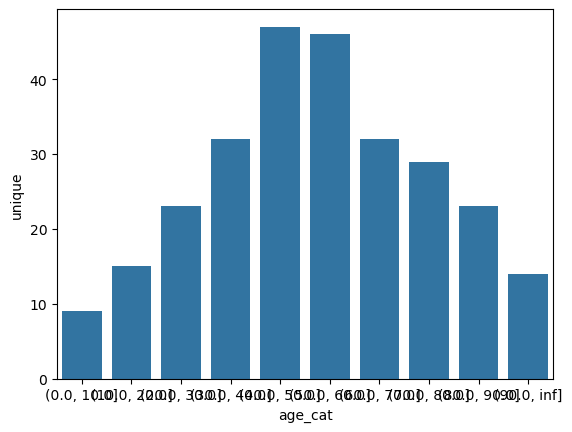

In [123]:
sns.barplot(df_aux_gb_agecat_entry.reset_index(),x="age_cat", y="unique")

In [124]:
filter_aux = df_merge_all_5["entry_channel"].isna()

df_merge_all_5[filter_aux]

,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,entry_date_TRANSFORMED,age_cat,salary_imput_1,segment_imput_2,salary_imput_2,segment_imput_4
30736,1035728,2018-01-28,ES,45.0,H,23,N,NaN,2015-07-30,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-07-30,"(20.0, 30.0]",NaN,03 - UNIVERSITARIO,87777.54,NaN
448039,1035728,2018-02-28,ES,45.0,H,23,N,NaN,2015-07-30,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-07-30,"(20.0, 30.0]",NaN,03 - UNIVERSITARIO,87777.54,NaN
707559,1035728,2018-03-28,ES,45.0,H,23,N,NaN,2015-07-30,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-07-30,"(20.0, 30.0]",NaN,03 - UNIVERSITARIO,87777.54,NaN
938648,1035728,2018-04-28,ES,45.0,H,23,N,NaN,2015-07-30,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-07-30,"(20.0, 30.0]",NaN,03 - UNIVERSITARIO,87777.54,NaN
998956,1035728,2018-05-28,ES,45.0,H,23,N,NaN,2015-07-30,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2015-07-30,"(20.0, 30.0]",NaN,03 - UNIVERSITARIO,87777.54,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5947928,1185110,2019-05-28,ES,41.0,V,22,N,NaN,2016-09-27,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-09-27,"(20.0, 30.0]",NaN,03 - UNIVERSITARIO,87777.54,NaN
5947993,1185013,2019-05-28,ES,23.0,V,53,N,NaN,2019-05-14,NaN,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2019-05-14,"(50.0, 60.0]",NaN,02 - PARTICULARES,96539.22,NaN
5956953,1168909,2019-05-28,ES,36.0,V,43,N,NaN,2016-08-23,NaN,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-08-23,"(40.0, 50.0]",NaN,02 - PARTICULARES,89810.52,NaN
5958078,1173729,2019-05-28,ES,14.0,H,33,N,NaN,2016-09-09,NaN,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2016-09-09,"(30.0, 40.0]",NaN,02 - PARTICULARES,84640.77,NaN


In [125]:
#Imputación
for i,idx in enumerate(df_merge_all_5[filter_aux].index):
    age_to_search = df_merge_all_5.loc[idx,"age_cat"]
    ent_channel_to_imput = df_aux_gb_agecat_entry.loc[(df_aux_gb_agecat_entry["age_cat"]==age_to_search), "top"]
    #print(ent_channel_to_imput.to_list()[0])
    
    df_merge_all_5.loc[idx,"entry_channel_imput"] = ent_channel_to_imput.to_list()[0]


In [126]:
filter_aux = df_merge_all_5["entry_channel"].isna()
df_merge_all_5[filter_aux][["age_cat", "entry_channel", "entry_channel_imput"]]

,age_cat,entry_channel,entry_channel_imput
30736,"(20.0, 30.0]",NaN,KHE
448039,"(20.0, 30.0]",NaN,KHE
707559,"(20.0, 30.0]",NaN,KHE
938648,"(20.0, 30.0]",NaN,KHE
998956,"(20.0, 30.0]",NaN,KHE
...,...,...,...
5947928,"(20.0, 30.0]",NaN,KHE
5947993,"(50.0, 60.0]",NaN,KFC
5956953,"(40.0, 50.0]",NaN,KFC
5958078,"(30.0, 40.0]",NaN,KFC


## Análisis Univariable

In [132]:
#listado de variables 
list_numerics, list_booleans, list_categorics = list_type_variables(df_merge_all_5)


[None, None, None, None, None, None]

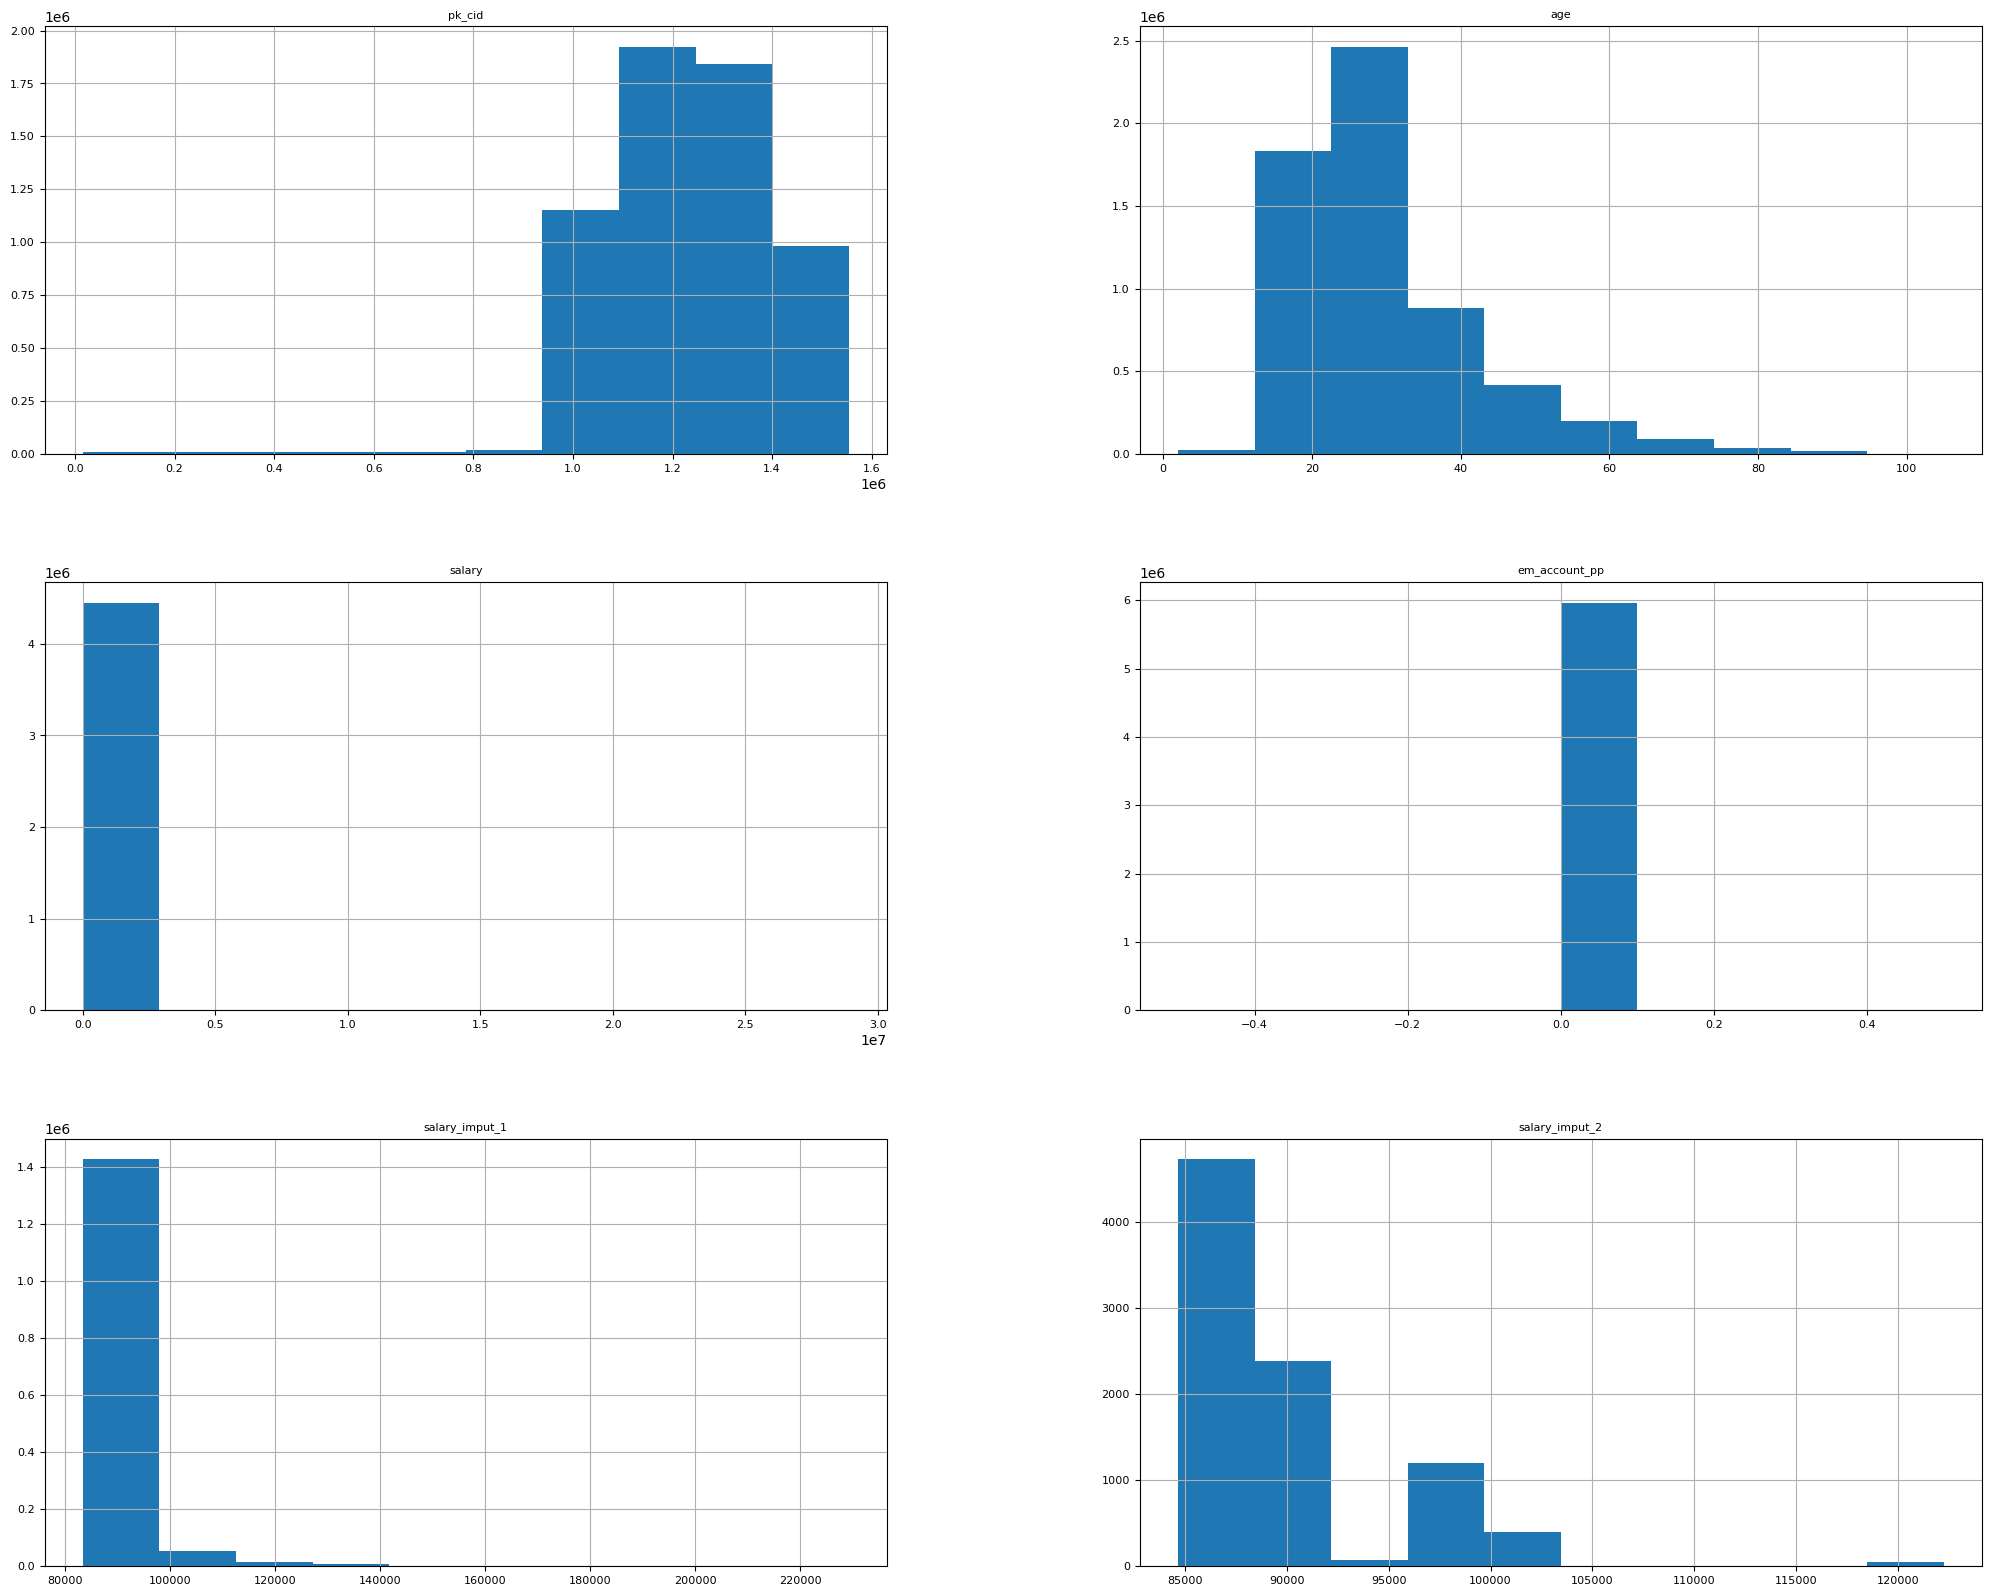

In [133]:
#### Variables numéricas
fig = df_merge_all_5[list_numerics].hist(figsize=(25,20), xlabelsize=8, ylabelsize=8)
[x.title.set_size(8) for x in fig.ravel()]

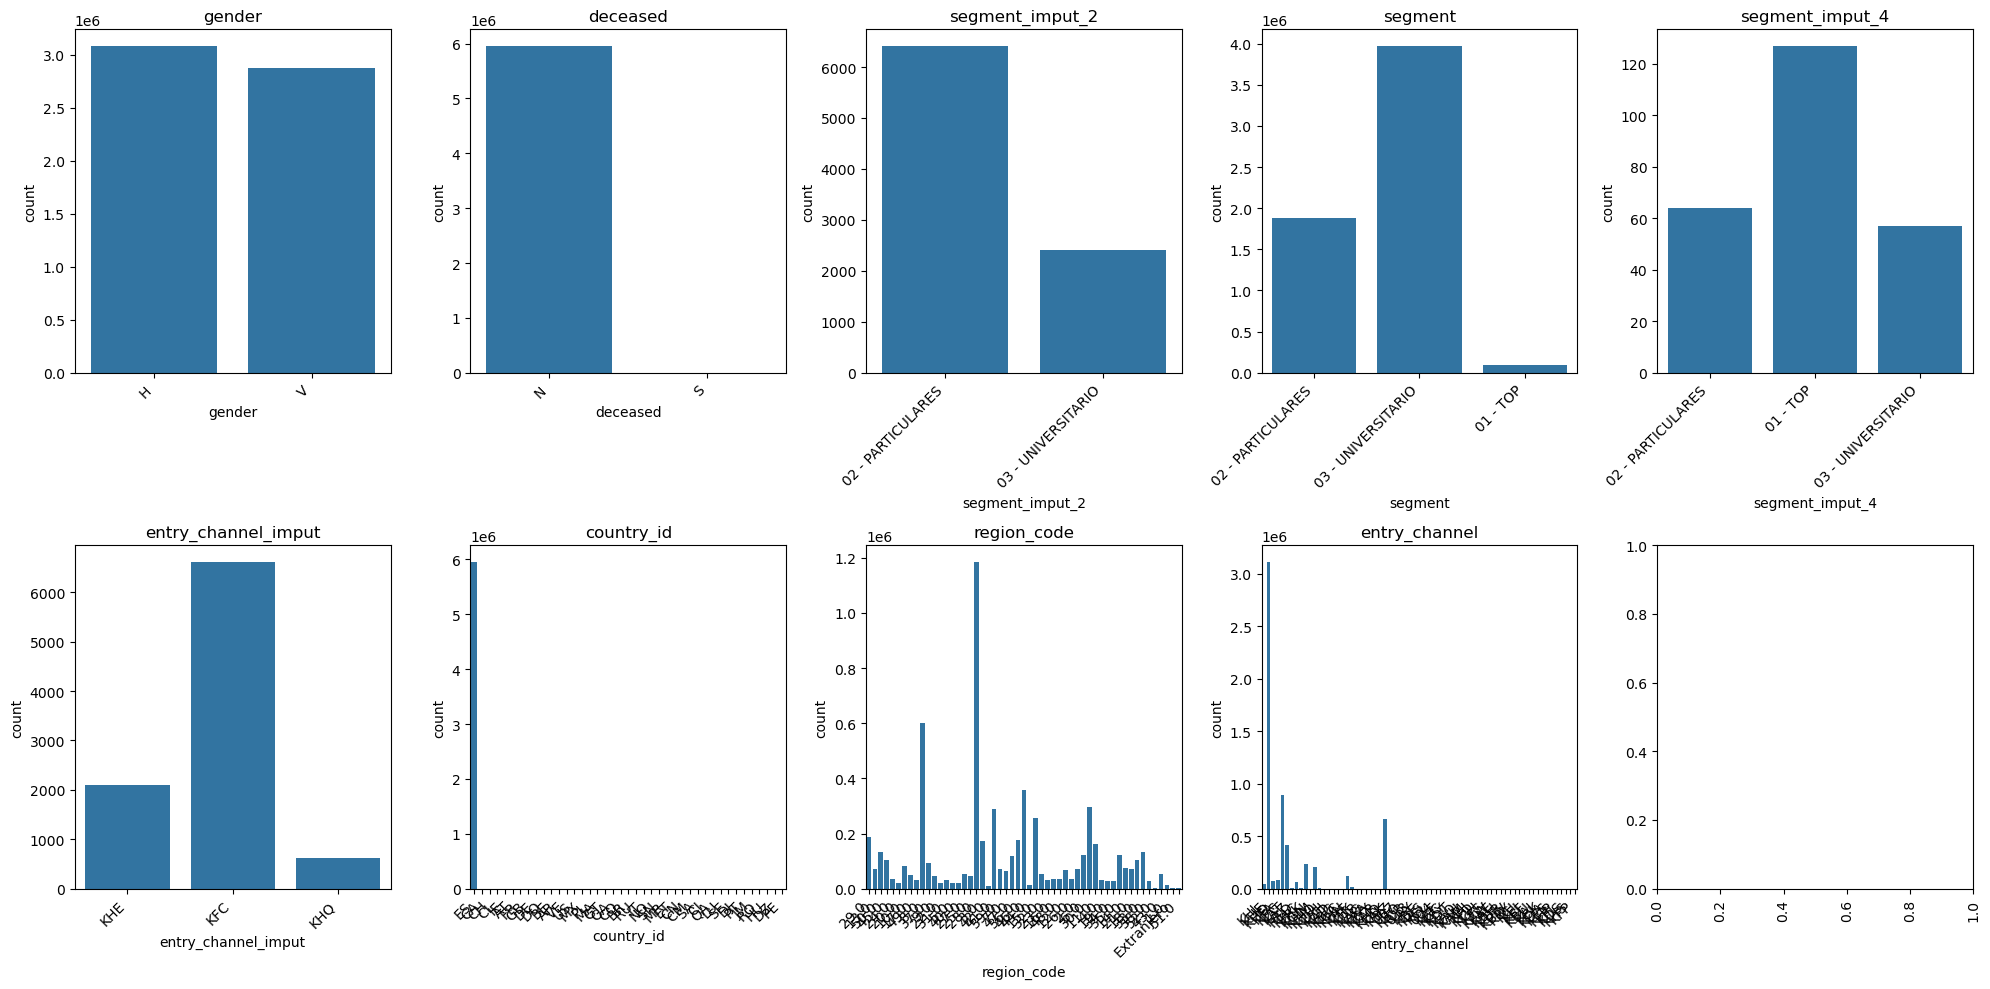

In [134]:
#### Variables categóricas
plot_categorics(df_merge_all_5, list_categorics)

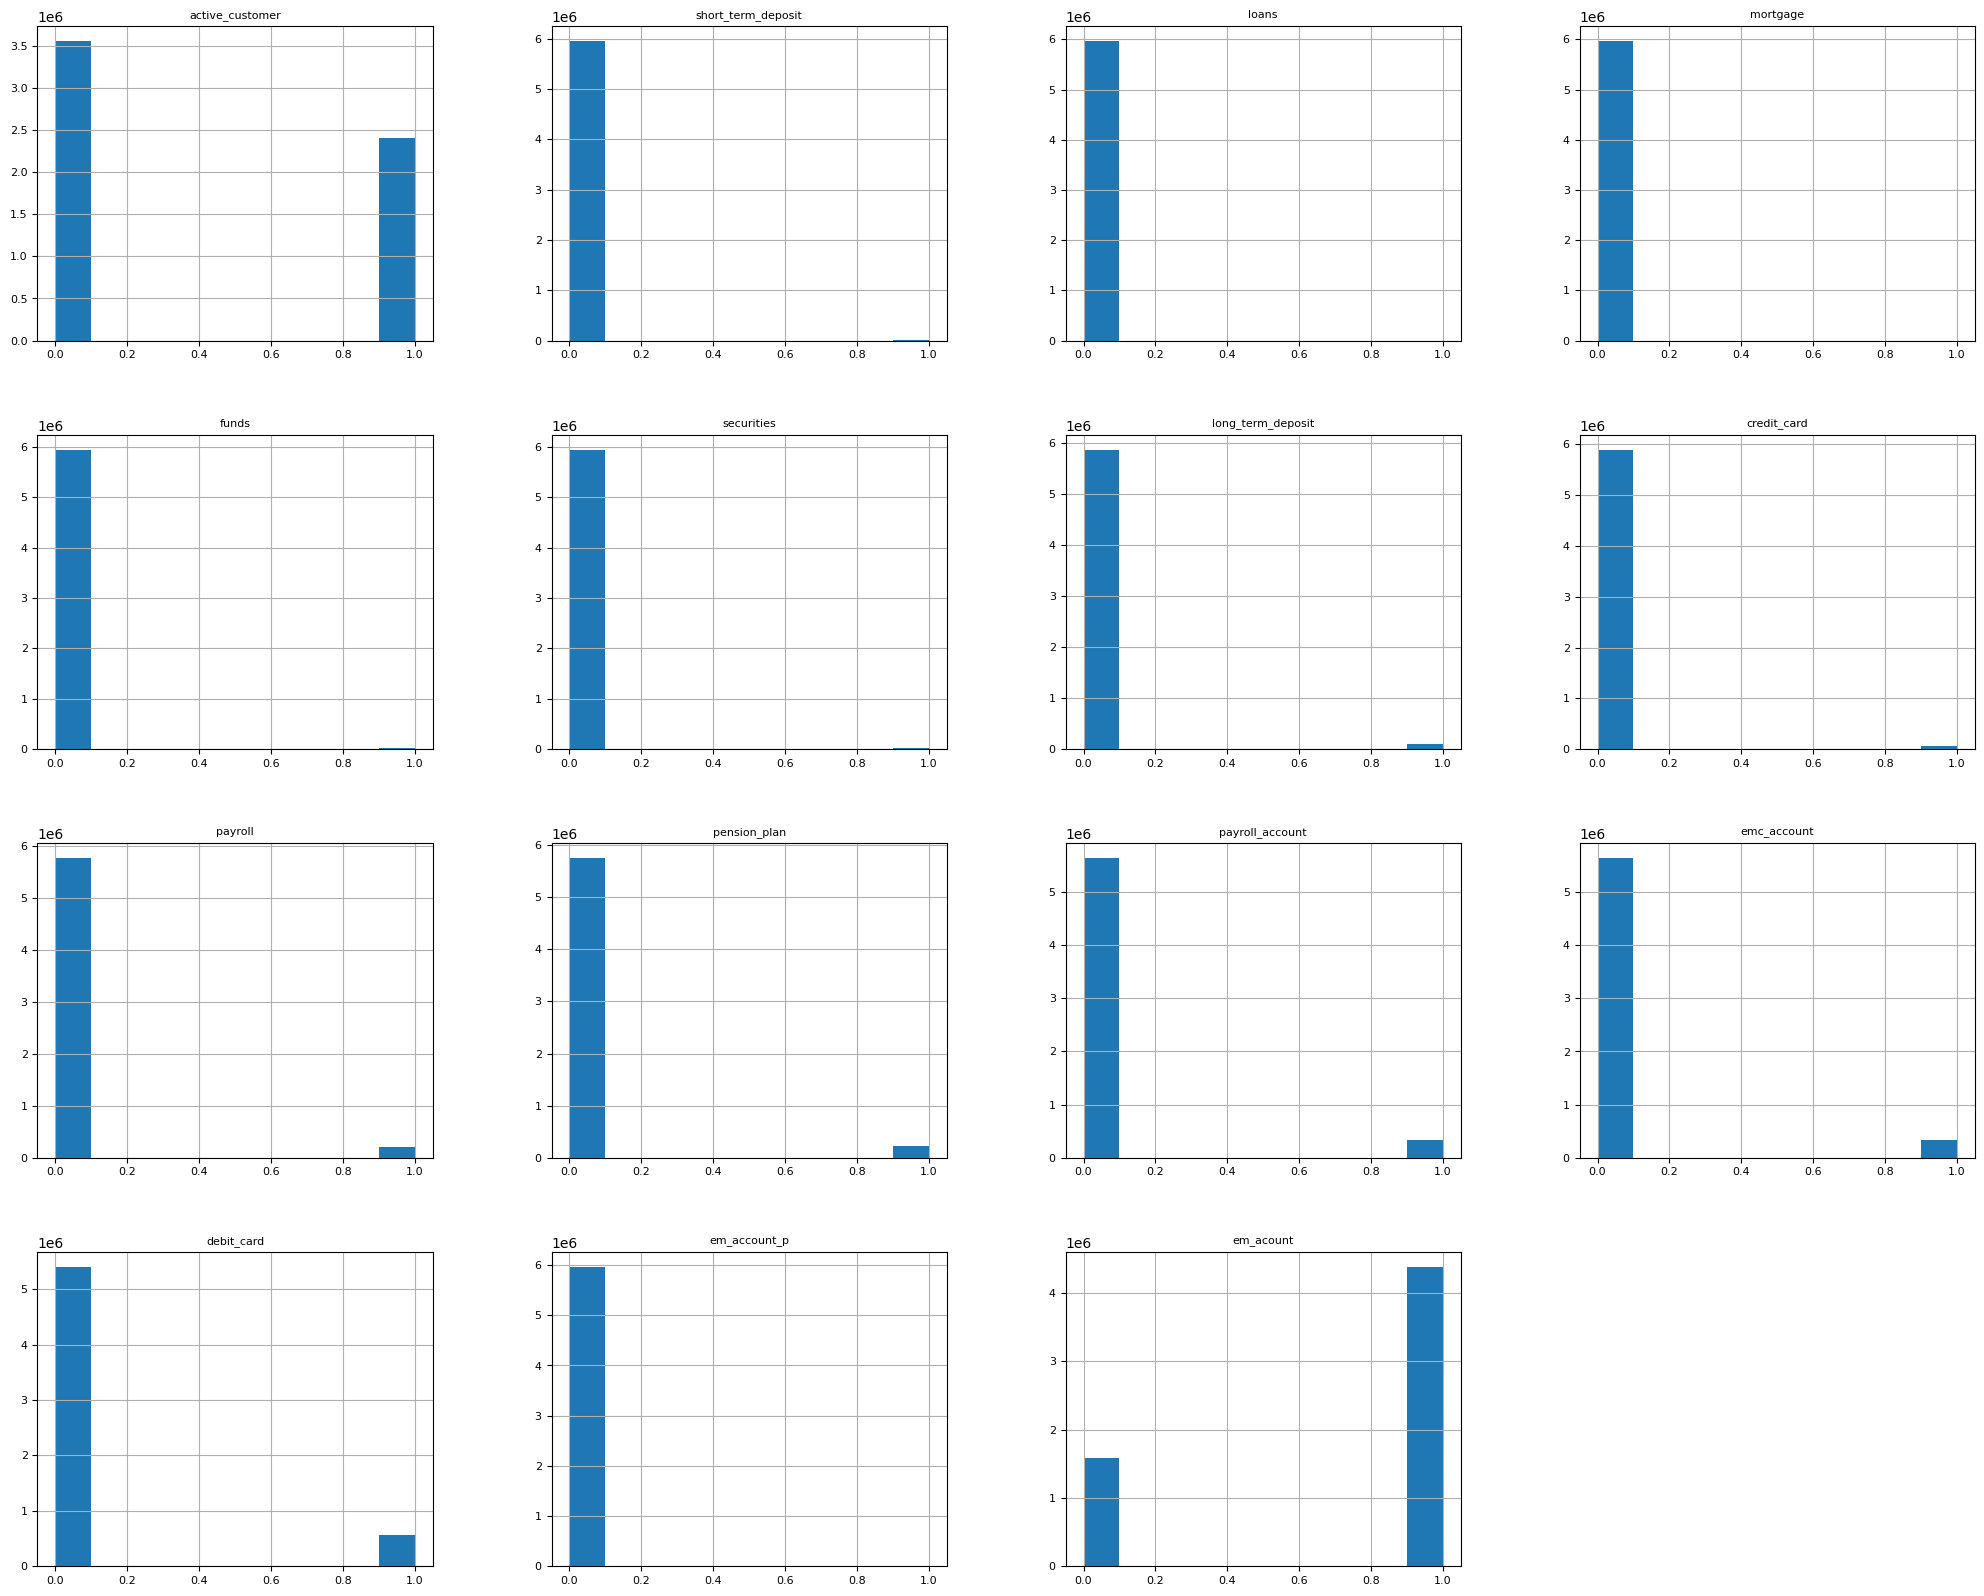

In [135]:
### Variables binárias
fig = df_merge_all_5[list_booleans].hist(figsize=(25,20), xlabelsize=8, ylabelsize=8);
[x.title.set_size(8) for x in fig.ravel()];


In [136]:
### Listado de variables: Tipos y valores
info_features_content(df_merge_all_5)

,Variable,Type,NUnique,Unique
0,pk_cid,int64,456373,"[1375586, 1050611, 1050612, 1050613, 1050614, 1050615, 1050616, 1050617, 1050619, 1050620, 1050621, 1050622, 1050623, 1050624, 1050625, 1050626, 1050610, 1050627, 1050609, 1050605, 1050582, 1050586, 1050588, 1050589, 1050591, 1050592, 1050595, 1050596, 1050597, 1050598, 1050599, 1050601, 1050602, 1050603, 1050604, 1050607, 1050580, 1050628, 1050630, 1050669, 1050670, 1050676, 1050679, 1050680, 1050686, 1050688, 1050693, 1050694, 1050697, 1050703, 1050704, 1050706, 1050707, 1050710, 1050663, 1050629, 1050662, 1050660, 1050632, 1050633, 1050634, 1050635, 1050636, 1050639, 1050641, 1050642, 1050647, 1050648, 1050651, 1050652, 1050655, 1050658, 1050659, 1050661, 1050711, 1050579, 1050577, 1050507, 1050508, 1050509, 1050511, 1050512, 1050513, 1050514, 1050515, 1050516, 1050517, 1050520, 1050521, 1050522, 1050523, 1050524, 1050505, 1050525, 1050504, 1050502, 1050487, 1050488, 1050489, 1050490, ...]"
1,pk_partition,datetime64[ns],17,"[2018-01-28T00:00:00.000000000, 2018-02-28T00:00:00.000000000, 2018-03-28T00:00:00.000000000, 2018-04-28T00:00:00.000000000, 2018-05-28T00:00:00.000000000, 2018-06-28T00:00:00.000000000, 2018-07-28T00:00:00.000000000, 2018-08-28T00:00:00.000000000, 2018-09-28T00:00:00.000000000, 2018-10-28T00:00:00.000000000, 2018-11-28T00:00:00.000000000, 2018-12-28T00:00:00.000000000, 2019-01-28T00:00:00.000000000, 2019-02-28T00:00:00.000000000, 2019-03-28T00:00:00.000000000, 2019-04-28T00:00:00.000000000, 2019-05-28T00:00:00.000000000]"
2,country_id,object,41,"[ES, CA, CH, CL, IE, AT, FR, GB, DE, DO, BE, AR, VE, US, MX, PL, MA, GT, GA, CO, BR, RU, IT, NO, SN, MR, ET, CN, CM, SA, CI, QA, LU, SE, DJ, PT, JM, RO, HU, DZ, PE]"
3,region_code,object,53,"[29.0, 13.0, 50.0, 45.0, 24.0, 20.0, 10.0, 17.0, 49.0, 8.0, 37.0, 9.0, 22.0, 31.0, 5.0, 40.0, 27.0, 25.0, 28.0, 3.0, 42.0, 41.0, 39.0, 7.0, 47.0, 36.0, 46.0, 44.0, 15.0, 32.0, 23.0, 16.0, 48.0, 12.0, 26.0, 2.0, 6.0, 30.0, 11.0, 4.0, 19.0, 34.0, 35.0, 14.0, 21.0, 18.0, 33.0, 38.0, 52.0, 43.0, 1.0, Extranjero, 51.0]"
4,gender,object,2,"[H, V]"
5,age,int64,104,"[35, 23, 22, 24, 65, 28, 25, 26, 53, 27, 32, 37, 31, 39, 63, 33, 55, 42, 58, 38, 50, 30, 45, 44, 36, 29, 60, 57, 67, 47, 34, 48, 46, 54, 84, 15, 12, 8, 6, 83, 40, 77, 69, 52, 59, 43, 10, 9, 49, 41, 51, 78, 16, 11, 73, 62, 66, 17, 68, 82, 95, 96, 56, 61, 79, 72, 14, 19, 13, 86, 64, 20, 89, 71, 7, 70, 74, 21, 18, 75, 4, 80, 81, 5, 76, 92, 93, 85, 91, 87, 90, 94, 99, 98, 88, 97, 100, 101, 3, 2, ...]"
6,deceased,object,2,"[N, S]"
7,salary,float64,258629,"[87218.1, 35548.74, 122179.11000000002, 119775.54, nan, 22220.04, 295590.36, 113316.66, 113194.98, 72575.88, 113538.81, 61605.09, 68318.45999999999, 65608.35, 73432.47, 64620.56999999999, 64194.99000000001, 119173.88999999998, 58728.39, 86863.38, 68421.36, 90408.75, 74780.37, 120146.49, 91282.71, 131351.94, 113279.1, 70777.59, 77320.92, 64398.06, 171398.84999999998, 64031.25, 90431.85, 157191.69, 133092.33000000002, 37075.26, 245052.27, 104035.08, 57155.34, 53631.36, 72880.79999999999, 84061.95000000001, 106686.96, 132398.40000000002, 148080.45, 101919.09, 122456.91, 94683.27, 289211.4, 34406.58, 77346.51, 136930.23, 148677.18, 45345.18, 28359.36, 137894.63999999998, 139502.28, 149099.88, 95302.5, 110245.53, 60072.81, 34802.01, 79998.72, 55331.31, 173223.78, 47332.86, 111933.0, 107634.66, 55561.62, 215373.3, 64258.14, 59930.22, 162609.54, 74708.49, 68155.5, 77383.98, 56347.68000000001, 112330.35, 95392.71, 73020.18000000001, 101293.11000000002, 113580.78, 158207.40000000002, 60067...."
8,entry_date,datetime64[ns],1497,"[2018-01-12T00:00:00.000000000, 2015-08-10T00:00:00.000000000, 2015-08-16T00:00:00.000000000, 2015-08-14T00:00:00.000000000, 2015-08-15T00:00:00.000000000, 2015-08-20T00:00:00.000000000, 2015-10-10T00:00:00.000000000, 2015-08-17T00:00:00.000000000, 2017-07-09T00:00:00.000000000, 2017-10-28T00:00:00.000000000, 2015-12-28T00:00:00.000000000, 2015-08-13T00:00:00.000000000, 2015-08-31T00:00:00.000000000, 2015-08